# 1. Reading and Understanding the Data

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras import preprocessing
from keras.models import Sequential
from keras.layers import Conv2D,Dropout,Dense,Flatten,Conv2DTranspose,BatchNormalization,LeakyReLU,Reshape
from keras.losses import BinaryCrossentropy
import tensorflow as tf

### Helper Functions

In [4]:
def plot():
    
    noise = np.random.normal(size=(10, 100))
    generated_images = generator.predict(noise)
    
    plt.figure(figsize=(16,6))
    plt.suptitle("Generated Images")
    
    for k in range(10):
        
        plt.subplot(2, 5, k+1)
        plt.imshow(generated_images[k].reshape(28, 28), cmap='gray')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [5]:
train_data = pd.read_csv(".../fashion-mnist_train.csv")
test_data = pd.read_csv(".../fashion-mnist_test.csv")

In [6]:
print(train_data.shape)
print(test_data.shape)

(60000, 785)
(10000, 785)


In [7]:
print(train_data.head())

   label  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0      2       0       0       0       0       0       0       0       0   
1      9       0       0       0       0       0       0       0       0   
2      6       0       0       0       0       0       0       0       5   
3      0       0       0       0       1       2       0       0       0   
4      3       0       0       0       0       0       0       0       0   

   pixel9  ...  pixel775  pixel776  pixel777  pixel778  pixel779  pixel780  \
0       0  ...         0         0         0         0         0         0   
1       0  ...         0         0         0         0         0         0   
2       0  ...         0         0         0        30        43         0   
3       0  ...         3         0         0         0         0         1   
4       0  ...         0         0         0         0         0         0   

   pixel781  pixel782  pixel783  pixel784  
0         0         0         

In [8]:
print(train_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 359.3 MB
None


# 2. Preparing the Dataset

### Dropping the Labels

I will drop the labels since the training will not be with the target class.

In [9]:
X_train = train_data.drop('label',axis=1)
print(X_train.shape)

(60000, 784)


### Reshaping the Dataset

In [10]:
X_train=X_train.values
X_train=X_train.reshape(-1,28,28,1).astype('float32')
print(X_train.shape)

(60000, 28, 28, 1)


I will divide pixel values by 255 for optimal performance, and normalize the images to (-1, 1).

In [11]:
X_train = X_train / 255
X_train = X_train * 2 - 1

### Plotting the Dataset

There are couple of visualization plots of the dataset below.

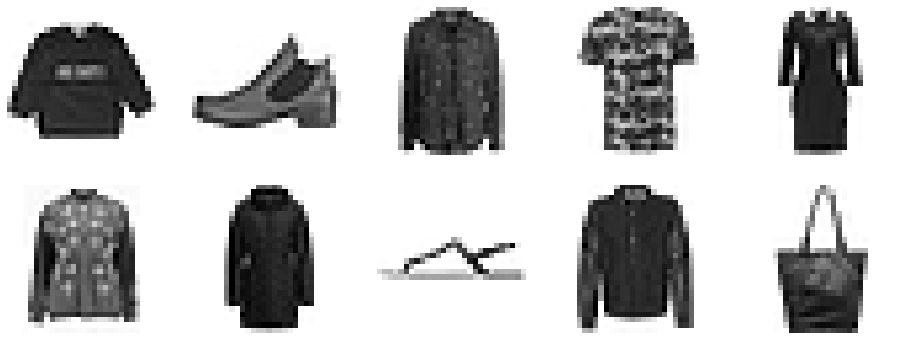

In [13]:
indexes = [0,1,2,3,4,5,6,7,8,9]
plt.figure(figsize=(16,6))
for index, item in enumerate(indexes, 1):
    plt.subplot(2,5,index)
    plt.imshow(X_train[item], cmap=plt.cm.binary)
    plt.axis('off')
plt.show()

# 3. Building GAN Model

### Building Generator Network

The generator uses tf.keras.layers.Conv2DTranspose (upsampling) layers to produce an image from a seed (random noise). 
Start with a Dense layer that takes this seed as input, then upsample several times until you reach the desired image size of 28x28x1. There are "ReLU activation" for each layer, except the output layer which uses "tanh".

In [14]:
def build_generator():
    
    model = Sequential()
    
    model.add(Dense(7 * 7 * 128, activation="relu", input_shape=(100,)))
    model.add(BatchNormalization())
    
    model.add(Reshape((7, 7, 128)))
  
    model.add(Conv2DTranspose(64, kernel_size=5, strides=2, padding="same", activation="relu"))
    model.add(BatchNormalization())
    
    model.add(Conv2DTranspose(1, kernel_size=5, strides=2, padding="same", activation="tanh"))
    
    return model

##### Create an image with untrained generator

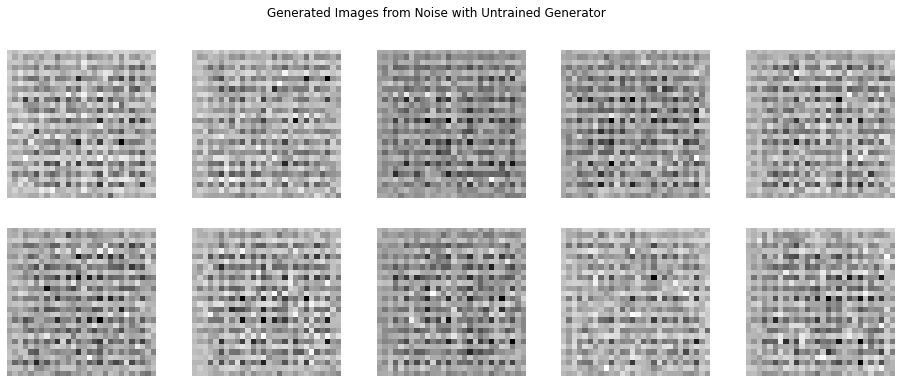

In [16]:
generator = build_generator()

noise=np.random.normal(size=(100,100))
generated_image = generator.predict(noise)

indexes = [0,5,10,15,20,25,30,35,40,45]
plt.figure(figsize=(16,6))
plt.suptitle('Generated Images from Noise with Untrained Generator')
for index, item in enumerate(indexes, 1):
    plt.subplot(2,5,index)
    plt.imshow(generated_image[item], cmap=plt.cm.binary)
    plt.axis('off')
plt.show()

### Building Discriminator Network

The discriminator is a CNN-based image classifier.

As an activation function, Leaky ReLUs are used since they solve the dying ReLU problem and allow a small negative value to pass through. In this way, the generator continue to learn by receiving the gradients from the discriminator.

Finally, the discriminator needs to output probabilities that's why we use a Sigmoid Activation.

In [17]:
def build_discriminator():
    
    model = Sequential()
    
    model.add(Conv2D(64, kernel_size=5, strides=2, padding="same", activation=LeakyReLU(0.3), input_shape=[28, 28, 1]))
    model.add(Dropout(0.5))
    
    model.add(Conv2D(128, kernel_size=5, strides=2, padding="same", activation=LeakyReLU(0.3)))
    model.add(Dropout(0.5))
    
    model.add(Flatten())
    model.add(Dense(1, activation="sigmoid"))
     
    return model

### Training 

In [19]:
# Building and compiling the discriminator
discriminator = build_discriminator()
discriminator.compile(optimizer='adam',loss='binary_crossentropy')
discriminator.trainable = False

In [20]:
GAN=Sequential([generator,discriminator])
GAN.compile(optimizer='adam',loss='binary_crossentropy')

Generated Images on epoch: 0


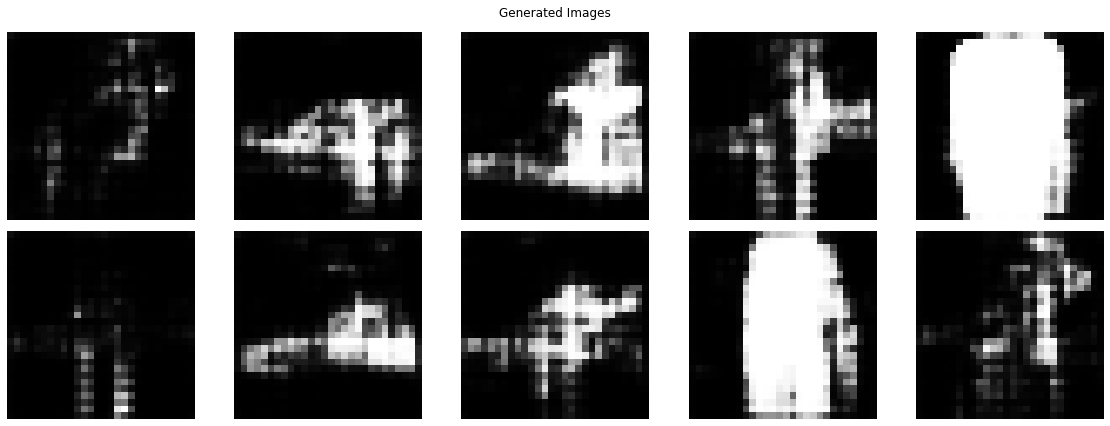

Generated Images on epoch: 5


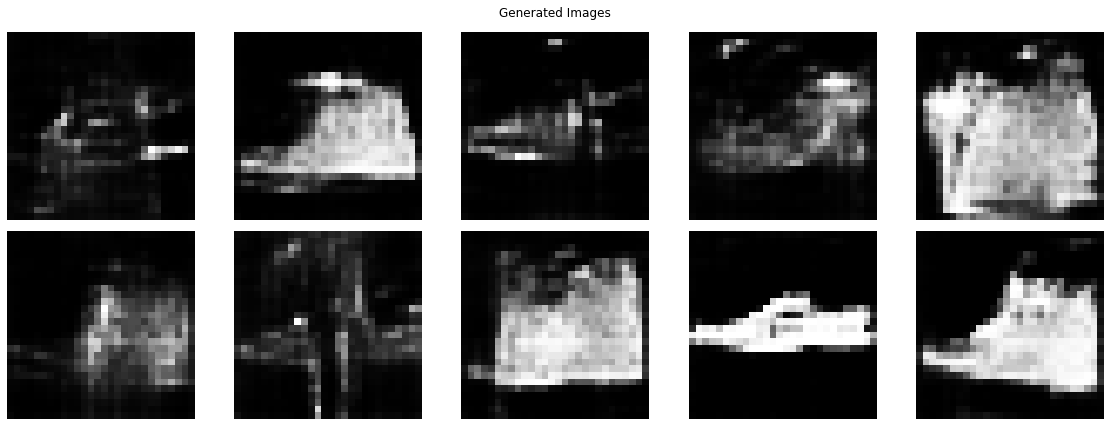

Generated Images on epoch: 10


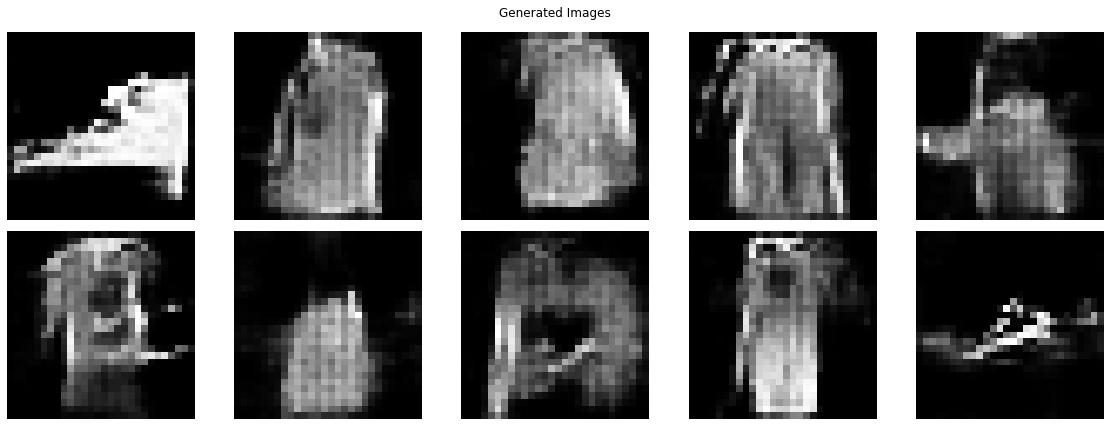

Generated Images on epoch: 15


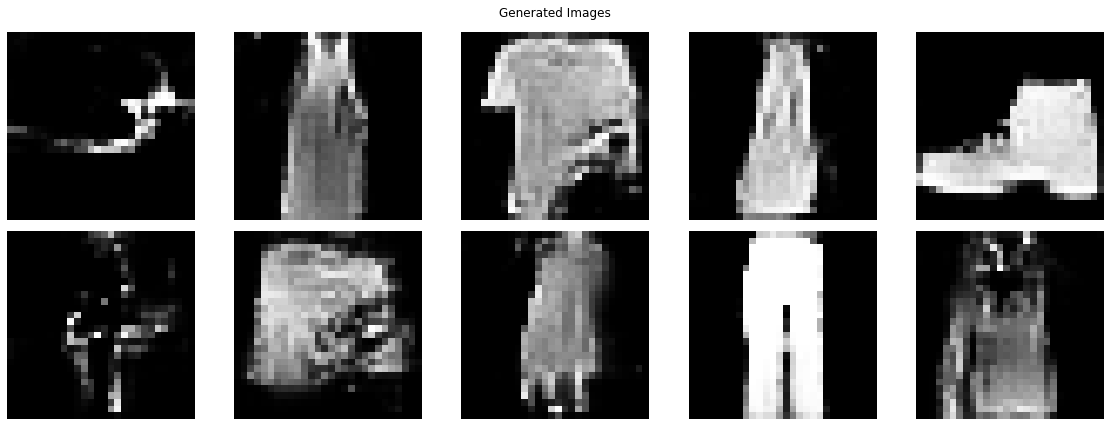

Generated Images on epoch: 20


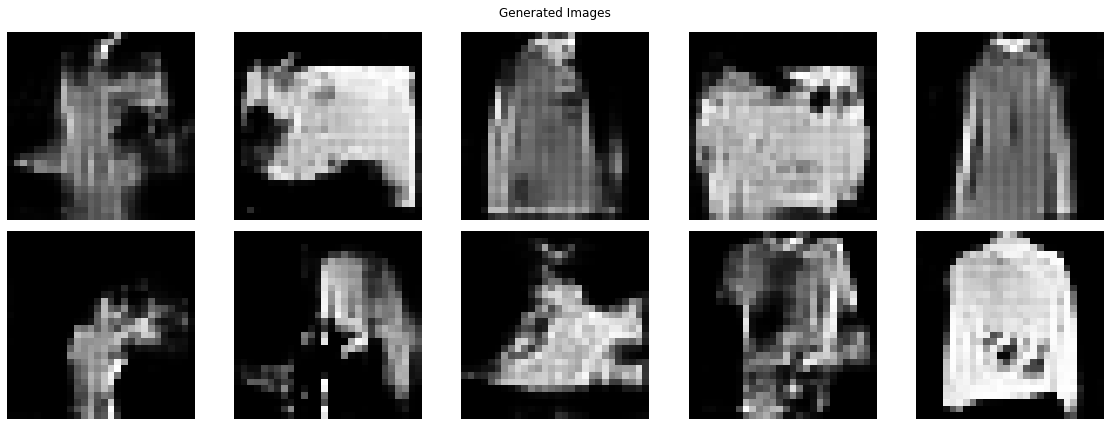

Generated Images on epoch: 25


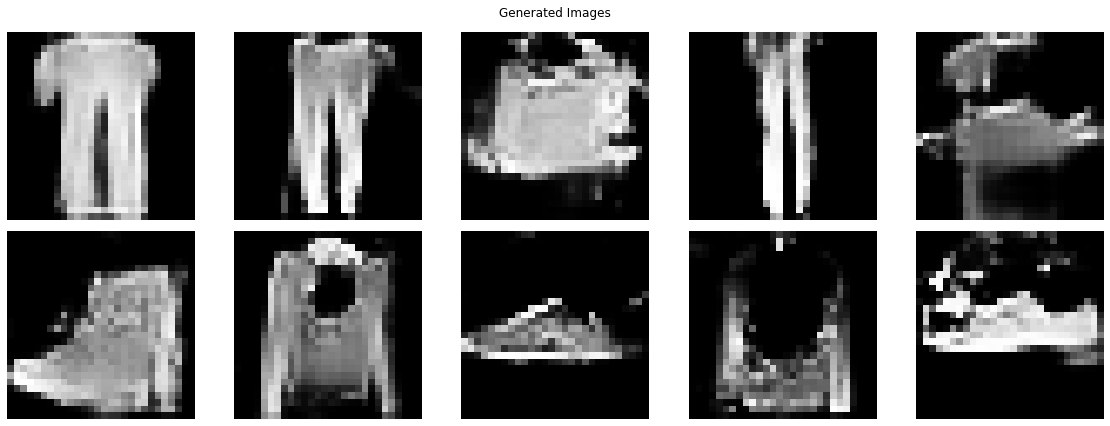

Generated Images on epoch: 30


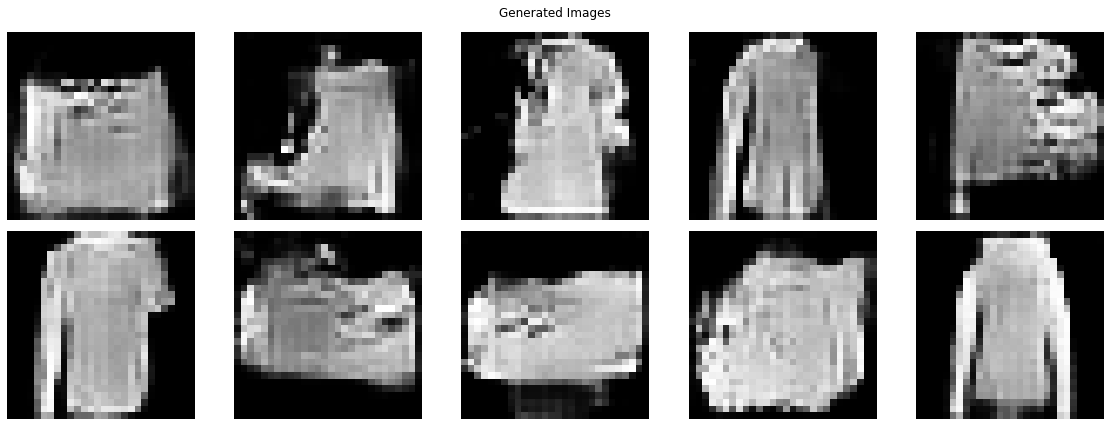

Generated Images on epoch: 35


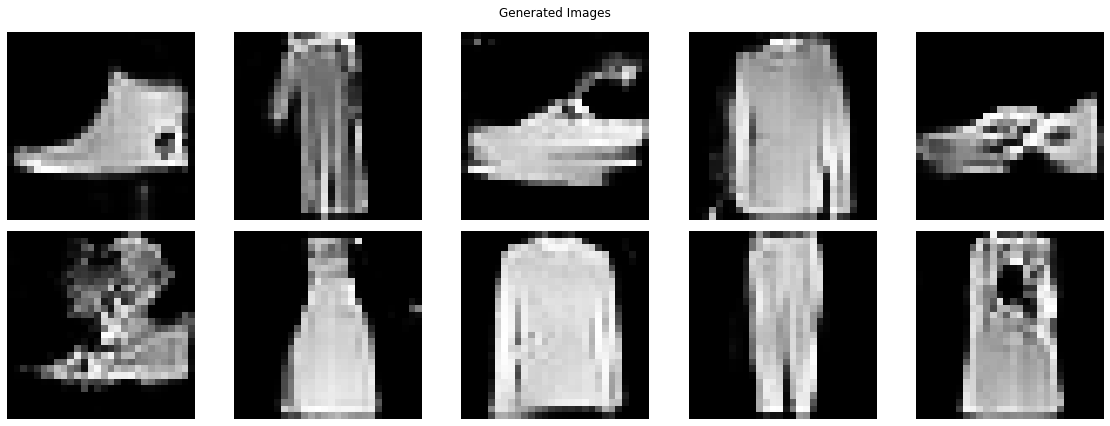

Generated Images on epoch: 40


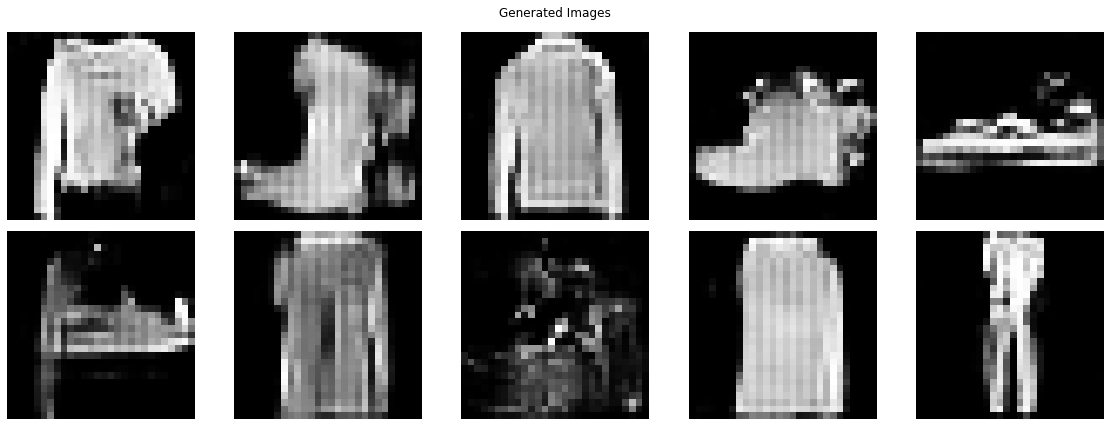

Generated Images on epoch: 45


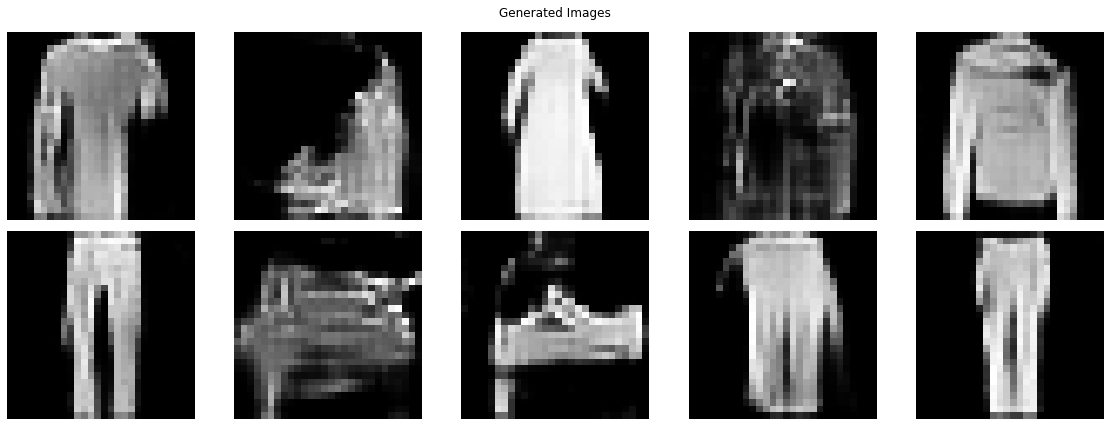

In [25]:
epochs = 50
batch_size = 100
noise_shape=100

for epoch in range(epochs):
    
    for i in range(X_train.shape[0]//batch_size):
            
            
            #  Training Discriminator
    
            # Sample noise and generate a batch of new images
            noise=np.random.normal(size=[batch_size,noise_shape])
            generated_image = generator.predict(noise)

            train_dataset = X_train[i*batch_size:(i+1)*batch_size]

            #Training discriminator on real images
            real_label=np.ones(shape=(batch_size,1))
            d_loss_real=discriminator.train_on_batch(train_dataset,real_label)


            #Training discriminator on fake images
            fake_label=np.zeros(shape=(batch_size,1))
            d_loss_fake=discriminator.train_on_batch(generated_image,fake_label)
            
            
            #  Training Generator

            g_loss=GAN.train_on_batch(noise, real_label)
            
            
    if epoch % 5 == 0:
        print("Generated Images on epoch:", epoch)
        plot()


# 4. Evaluation

### Comparing Some Actual and Generated Images After Training

### Plotting Actual Images

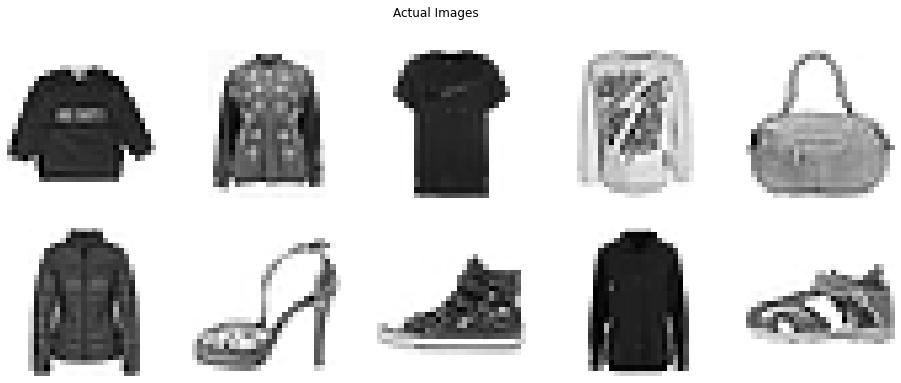

In [26]:
indexes = [0,5,10,15,20,25,30,35,40,45]
plt.figure(figsize=(16,6))
plt.suptitle('Actual Images')
for index, item in enumerate(indexes, 1):
    plt.subplot(2,5,index)
    plt.imshow(X_train[item], cmap=plt.cm.binary)
    plt.axis('off')
plt.show()

### Plotting Generated Images

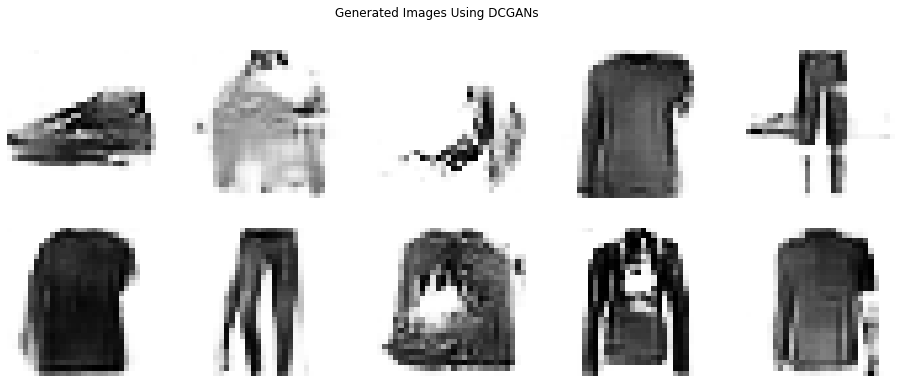

In [28]:
indexes = [0,5,10,15,20,25,30,35,40,45]
plt.figure(figsize=(16,6))
plt.suptitle('Generated Images Using DCGANs')
for index, item in enumerate(indexes, 1):
    plt.subplot(2,5,index)
    plt.imshow(generated_image[item], cmap=plt.cm.binary)
    plt.axis('off')
plt.show()